In [1]:
import sys
print(sys.executable)

/Users/BERL/Github/venv_sksparse/bin/python3.11


In [2]:
import numpy as np
import scipy as sp
import networkx as nx
from gstools import SRF, Exponential
from gstools.random import MasterRNG
import matplotlib.pyplot as plt
import ipywidgets
import plotly.graph_objects as go

from graphite_maps.enif import EnIF

In [3]:
def plot_field(i, title):
    plt.figure(figsize=(5, 5))
    # Find global min and max across all fields to set color scale
    vmin = np.min([np.min(u) for u in field])
    vmax = np.max([np.max(u) for u in field])
    plt.imshow(field[i], cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"{title} {i}")
    plt.colorbar()
    plt.show

def create_flattened_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
    return G

def draw_2d_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, node // dim_y) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size)
    plt.show()

def plot_field_from_vector(U_i, px, py, vmin, vmax, title="2D Field"):
    """
    Plots a 2D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create the plot
    plt.figure(figsize=(6, 5))
    plt.imshow(field_2d, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X dimension')
    plt.ylabel('Y dimension')
    plt.show()

In [4]:
px, py = 50, 50
p = px * py
n = 100

# Anisotropic exponential covariance Gaussian field

- variance $\sigma^2=1$
- correlation length $\lambda = (12,3)^T$
- rotation angle $\phi = \pi/8$

see [GSTools tutorial](https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html#creating-fancier-fields)

In [5]:
model = Exponential(dim=2, var=1, len_scale=[12., 3.], angles=np.pi/8)
srf = SRF(model)
seed = MasterRNG(20170519)

field = []
x, y = np.arange(px), np.arange(py)
for i in range(n):
    field.append(srf.structured([x,y], seed=seed()))

In [6]:
vmin = np.min([np.min(u) for u in field])
vmax = np.max([np.max(u) for u in field])

ipywidgets.interact(
    plot_field,
    i=ipywidgets.IntSlider(min=0, max=n - 1, step=1, value=0),
    title = "Prior parameter field",
)
plt.show()

interactive(children=(IntSlider(value=0, description='i', max=99), Text(value='Prior parameter field', descrip…

In [7]:
# Create the graph for the flattened field with separate dimensions
Graph_u = create_flattened_graph(px, py)
Graph_u.edges(101)  

EdgeDataView([(101, 51), (101, 100), (101, 102), (101, 151)])

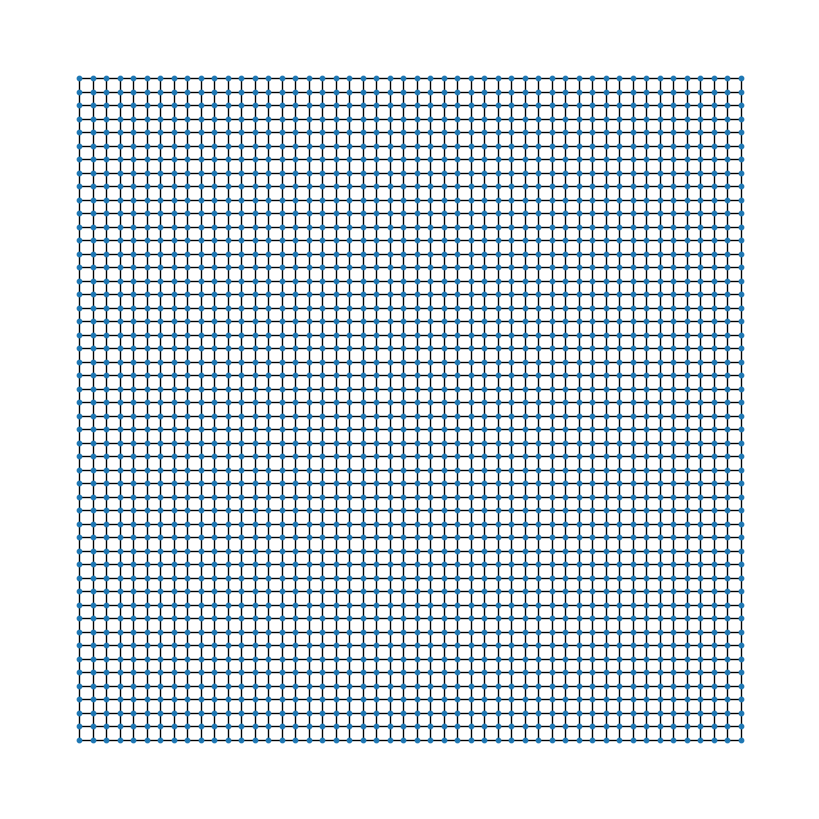

In [8]:
# Visualize the graph -- knowing 2-d structure
draw_2d_grid_graph(Graph_u, px, py, node_size=10)

In [9]:
U = np.zeros((n,p))
for i in range(n):
    U[i,:] = field[i].flatten()

# Compute responses

In [10]:
def h(U_i, j, a=1, b=5):
    return a * U_i[j] + b

In [11]:
m = min(px, py)  # Number of elements on the diagonal
Y = np.zeros((n, m))
a, b = 1.0, 5
for i in range(n):
    U_i = U[i, :]
    for k in range(m):
        j = k * (py + 1)  # Index for the diagonal element in the vectorized field
        Y[i, k] = h(U_i, j, a, b)

# Create observations -- we observe the diagonal in the 2D-field

In [12]:
d = np.repeat(8.0, m)

# Be specific about precision of noise
var_eps = 1.0
Prec_eps = sp.sparse.diags(
    [np.repeat(1/var_eps, m)], 
    offsets=[0],
    shape=(m, m), 
    format='csc'
)

## Ensemble Smoother

In [13]:
def ES(U, Y, d, Cov_epsilon):
    # Cross-covariance matrix C_UY has shape (p, m)
    C_UY = np.dot((U - U.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)
    print(C_UY.shape)

    # Compute the covariance of Y
    # Covariance matrix C_YY has shape (m, m)
    C_YY = np.dot((Y - Y.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)

    print(C_YY.shape)

    # Estimated K
    K = C_UY @ np.linalg.inv(C_YY + Cov_epsilon)
    print(K.shape)

    U_posterior = np.copy(U)
    for i in range(n):
        U_posterior[i,:] += K @ (d - Y[i,:])
    
    return U_posterior

In [14]:
U_posterior_es = ES(U, Y, d, np.linalg.inv(Prec_eps.A))

(2500, 50)
(50, 50)
(2500, 50)


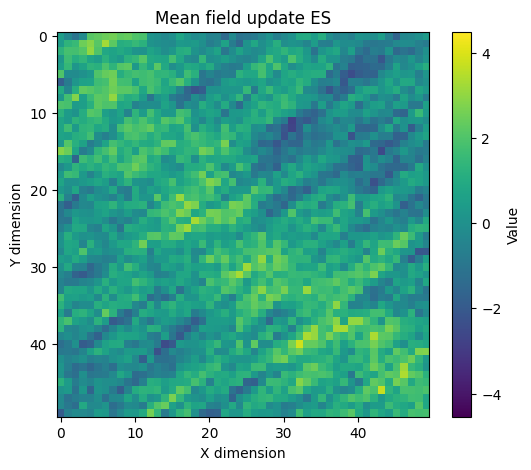

In [15]:
plot_field_from_vector(np.mean(U_posterior_es-U, axis=0), px, py, vmin, vmax, title="Mean field update ES")

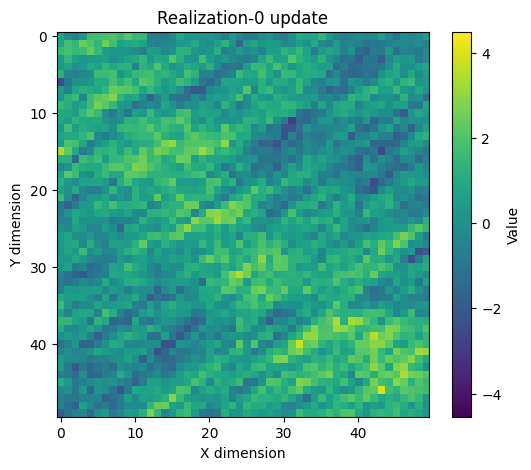

In [16]:
plot_field_from_vector(U_posterior_es[0,:]-U[0,:], px, py, vmin, vmax, title="Realization-0 update")

# Ensemble information filter

In [17]:
# Create EnIF object
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps)

In [ ]:
# Fit both precision and sparse linear map H
gtmap.fit(U, Y, learning_algorithm="influence-boost")

Learning sparse linear map for each response:  56%|████████████████████████████████████████████████████████████████████████▏                                                        | 28/50 [00:09<00:07,  2.89it/s]

In [ ]:
U_posterior = gtmap.transport(U, Y, d)

In [ ]:
plot_field_from_vector(np.mean(U_posterior-U, axis=0), px, py, vmin, vmax, title="EnIF Mean field update")

In [ ]:
plot_field_from_vector(U_posterior[0,:]-U[0,:], px, py, vmin, vmax, title="EnIF realization-0 update")

In [ ]:
plot_field_from_vector(np.std(U_posterior, axis=0), px, py, 0, 2, title="EnIF Standard deviations")

In [ ]:
plot_field_from_vector(np.std(U, axis=0), px, py, 0, 2, title="Prior standard deviations")

In [ ]:
print(gtmap.H)